In [1]:
import pandas as pd
import io
import os
import gzip
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import swifter
import warnings
import time
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/opt/conda/lib/python3.9/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [8]:
os.getcwd()

'/home/szhou/private/DSC180/notebooks'

In [5]:
os.pardir

'..'

In [23]:
parent = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [37]:
os.path.abspath(os.path.join(os.getcwd(), os.pardir))

'/home/szhou/private/DSC180'

In [33]:
import json

In [41]:
json.load(open(os.path.abspath(os.path.join(os.getcwd(), os.pardir)) + '/config/data-params.json'))

{'data_path': 'data',
 'vcf_name': 'ALL.chr22.phase1_release_v3.20101123.snps_indels_svs.genotypes.vcf.gz',
 'expressions_name': 'GD462.GeneQuantRPKM.50FN.samplename.resk10.txt',
 'populations_name': 'ALL_1000G_phase1integrated_v3.sample',
 'vcf_out_prefix': 'chr22',
 'chromosome': '22',
 'populations': ['CEU'],
 'cis_thresh': 500000}

In [27]:
parent + '/' + 'data/raw'

'/home/szhou/private/DSC180/data/raw'

In [20]:
os.path.join(os.path.join(os.getcwd(), os.pardir), 'data/raw')

'/home/szhou/private/DSC180/notebooks/../data/raw'

In [15]:
os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), 'data/raw')) + 

'/home/szhou/private/DSC180/data/raw'

In [13]:
os.system(f"cd {os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), 'data/raw'))}")

0

In [14]:
os.system(f"pwd")

/home/szhou/private/DSC180/notebooks


0

In [2]:
def get_vcf_names(vcf_path):
    with open(vcf_path, "rt") as ifile:
        for line in ifile:
            if line.startswith("#CHROM"):
                vcf_names = [x for x in line.split('\t')]
                break
    ifile.close()
    return vcf_names

In [3]:
expressions = pd.read_csv('data/GD462.GeneQuantRPKM.50FN.samplename.resk10.txt.gz', sep='\t')

In [4]:
expressions_22 = expressions[expressions['Chr'] == '22']

In [5]:
expressions_22.head()

,TargetID,Gene_Symbol,Chr,Coord,HG00096,HG00097,HG00099,HG00100,HG00101,HG00102,...,NA20810,NA20811,NA20812,NA20813,NA20814,NA20815,NA20816,NA20819,NA20826,NA20828
22,ENSG00000249263.2,ENSG00000249263.2,22,17140518,0.340656,0.318942,-0.009145,0.231503,0.089713,0.482984,...,0.032117,0.213629,0.225474,0.134216,0.128749,0.060841,0.298061,-0.011292,0.058276,-0.013384
29,ENSG00000224688.1,ENSG00000224688.1,22,21496660,4.194827,3.369440,2.335470,4.477910,3.641758,3.296741,...,4.669164,3.918440,4.977372,3.253683,3.322997,6.613617,3.438039,3.768840,3.248447,4.300825
45,ENSG00000075240.12,ENSG00000075240.12,22,46971909,3.531803,3.635541,1.251434,3.007745,3.574070,4.569758,...,4.057426,3.736969,3.156168,6.785470,5.646243,2.418243,4.678466,4.626435,5.101994,4.100622
81,ENSG00000099937.6,ENSG00000099937.6,22,21128167,0.519054,0.399216,0.078965,0.145628,0.446993,0.217271,...,0.621082,0.414906,1.047612,0.353794,0.253339,0.492650,0.449070,0.081118,0.164197,0.287428
85,ENSG00000099998.12,ENSG00000099998.12,22,24641110,0.073630,0.041109,0.017493,-0.020552,0.000059,-0.007782,...,0.045730,0.003584,0.027056,0.007583,0.063843,0.059052,-0.008820,0.017421,0.010471,0.105646


In [43]:
pops = pd.read_csv(os.path.abspath(os.path.join(os.path.join(os.getcwd(), os.pardir), 'data/raw')) + '/ALL_1000G_phase1integrated_v3.sample', sep=' ')

In [45]:
pops['population'].value_counts()

CHS    100
TSI     98
CHB     97
LWK     97
FIN     93
GBR     89
JPT     89
YRI     88
CEU     85
MXL     66
ASW     61
CLM     60
PUR     55
IBS     14
Name: population, dtype: int64

In [7]:
pops.head()

,sample,population,group,sex
0,HG00096,GBR,EUR,1
1,HG00097,GBR,EUR,2
2,HG00099,GBR,EUR,2
3,HG00100,GBR,EUR,2
4,HG00101,GBR,EUR,1


## Whole Chr22

In [8]:
def get_cis_snps(x, cis_thresh, snps):
    return snps['POS'][(abs(snps['POS'] - x['Coord']) < cis_thresh)].index

In [13]:
def regress(x, snps, total_count, samples):
    exp = x.iloc[4:-1]
    
    valid_keys_exp = exp.index.intersection(samples)
    exp = exp.loc[valid_keys_exp]
    
    sig_alleles = []
    
    for snp in x['local']:

        allele = snps.loc[snp]
        
        valid_keys_allele = allele.index.intersection(samples)
        allele = allele.loc[valid_keys_allele]

        merged = pd.merge(exp, allele, left_index=True, right_index=True)
        merged.columns = ['expression', 'allele']

        slope, intercept, r_value, p_value, std_err = linregress(merged['allele'].values.astype(float), merged['expression'].values.astype(float))
        
        if p_value <= 0.05 / total_count:
            sig_alleles.append(np.array([snp, slope, std_err, p_value]))
            
        
    return sig_alleles
    

In [14]:
names = get_vcf_names('data/chr22_common.vcf')
vcf = pd.read_csv('data/chr22_common.vcf', chunksize=50_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)

significants = 0
p_values = []
total_count = 0


for i, chunk in enumerate(vcf):

    common = chunk
    
    expressions_22.loc[:, 'local'] = expressions_22.swifter.apply(get_cis_snps, cis_thresh=500_000, snps=common, axis=1)
    alleles = common.iloc[:, 9:].applymap(lambda x: sum(int(i) for i in str(x).split('/')))
    
    total_count += expressions_22['local'].apply(len).sum()

Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

In [15]:
total_count

1722438

In [16]:
start = time.time()

target_pops = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']
samples = pops['sample'][pops['population'].isin(target_pops)]

names = get_vcf_names('data/chr22_common.vcf')
vcf = pd.read_csv('data/chr22_common.vcf', chunksize=50_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)

significants = pd.DataFrame(columns=['gene', 'snp', 'pos', 'slope', 'SE', 'pvalue'])

for i, chunk in enumerate(vcf):
    print(i)
    
    expressions_22.loc[:, 'local'] = expressions_22.swifter.apply(get_cis_snps, cis_thresh=500_000, snps=chunk, axis=1)
    alleles = chunk.iloc[:, 9:].applymap(lambda x: sum(int(i) for i in str(x).split('/')))
    alleles.columns = alleles.columns.str.split('_').str[0].str.strip()

    expressions_22.loc[:, 'info'] = expressions_22.apply(regress, snps=alleles, total_count=total_count, samples=samples, axis=1)
    
    for idx, row in expressions_22.iterrows():
    
        for sig in row['info']:
            record = pd.DataFrame.from_dict({
                'gene': [row['TargetID']],
                'snp': [chunk.loc[int(sig[0])]['ID']],
                'pos': [chunk.loc[int(sig[0])]['POS']],
                'slope': [sig[1]],
                'SE': [sig[2]],
                'pvalue': [sig[3]]
            })
            
            significants = pd.concat([significants, record], ignore_index=True)
    
end = time.time()

0


Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

1


Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

2


Pandas Apply:   0%|          | 0/633 [00:00<?, ?it/s]

In [17]:
print(end - start)

4972.343889951706


In [18]:
significants.to_csv('chr22_all_test.csv', index=False)

In [ ]:
significants

In [ ]:
significants[['snp', 'pvalue']].to_csv('week7.tsv', index=False, sep='\t')

In [ ]:
significants

In [ ]:
total_count

In [289]:
sig = pd.read_csv('sign.csv')

In [295]:
sig.groupby('gene').count()['snp'].idxmax()

'ENSG00000167074.9'

In [ ]:
ENSG00000184674.7,rs4822458,24265659,5.202275544830664,0.33766072431363464,9.350402830432507e-43

In [36]:
names = get_vcf_names('data/chr22_common.vcf')
vcf = pd.read_csv('data/chr22_common.vcf', chunksize=50_000, comment='#',low_memory=False, delim_whitespace=True, header=None, names=names)
ch = vcf.get_chunk()

In [52]:
ex = expressions_22[expressions_22['Gene_Symbol'] == 'ENSG00000184674.7'].T.iloc[4:-2]

In [57]:
al = ch[ch['ID'] == 'rs4822458'].iloc[:, 9:].applymap(lambda x: sum(int(i) for i in str(x).split('/')))
al.columns = al.columns.str.split('_').str[0].str.strip()
al = al.T

In [58]:
ex

,20720
HG00096,14.403702
HG00097,14.092984
HG00099,7.085624
HG00100,20.933824
HG00101,8.44806
...,...
NA20815,0.816503
NA20816,5.935849
NA20819,22.857306
NA20826,16.680807


In [79]:
merged = pd.merge(ex, al, left_index=True, right_index=True)
merged.columns = ['expression', 'genotype']

In [80]:
merged

,expression,genotype
HG00096,14.403702,1
HG00097,14.092984,2
HG00099,7.085624,1
HG00100,20.933824,2
HG00101,8.44806,1
...,...,...
NA20815,0.816503,0
NA20816,5.935849,1
NA20819,22.857306,1
NA20826,16.680807,2


In [81]:
merged

,expression,genotype
HG00096,14.403702,1
HG00097,14.092984,2
HG00099,7.085624,1
HG00100,20.933824,2
HG00101,8.44806,1
...,...,...
NA20815,0.816503,0
NA20816,5.935849,1
NA20819,22.857306,1
NA20826,16.680807,2


In [86]:
import matplotlib.pyplot as plt

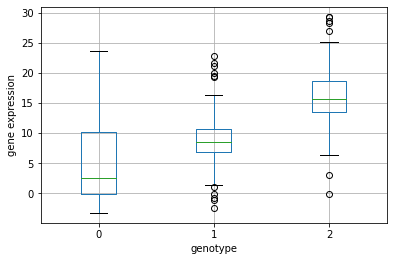

In [264]:
merged.boxplot(column=['expression'], by='genotype')
plt.suptitle('')
plt.title('')
plt.ylabel('gene expression')
plt.savefig('boxwhisker', bbox_inches='tight')

In [265]:
barplot = pd.DataFrame(columns = ['POP', 'CNT'])

barplot = pd.concat([barplot, pd.DataFrame({'POP': ['CEU'], 'CNT': [pd.read_csv('chr22_CEU.csv').shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['FIN'], 'CNT': [pd.read_csv('chr22_FIN.csv').shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['GBR'], 'CNT': [pd.read_csv('chr22_GBR.csv').shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['TSI'], 'CNT': [pd.read_csv('chr22_TSI.csv').shape[0]]})], ignore_index=True)
barplot = pd.concat([barplot, pd.DataFrame({'POP': ['YRI'], 'CNT': [pd.read_csv('chr22_YRI.csv').shape[0]]})], ignore_index=True)

In [266]:
barplot

,POP,CNT
0,CEU,731
1,FIN,857
2,GBR,1273
3,TSI,1026
4,YRI,562


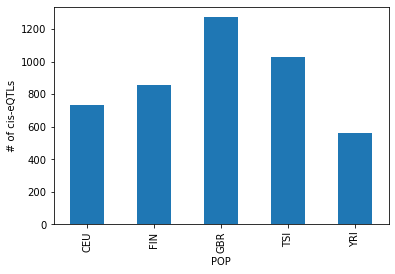

In [267]:
barplot.plot(kind='bar', x='POP', y='CNT', legend=False, ylabel='# of cis-eQTLs')
plt.savefig('barplot', bbox_inches='tight')

In [268]:
ceu_cnt = dict()
ceu_cnt['20+'] = 0
ceu = pd.read_csv('chr22_CEU.csv')
for i in range(1, 169):
    if i < 20:
        if i in ceu.groupby('gene')['snp'].count().value_counts().index:
            ceu_cnt[i] = ceu.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            ceu_cnt[i] = 0
            
    else :
        if i in ceu.groupby('gene')['snp'].count().value_counts().index:
            ceu_cnt['20+'] += ceu.groupby('gene')['snp'].count().value_counts().loc[i]

In [269]:
fin_cnt = dict()
fin_cnt['20+'] = 0
fin = pd.read_csv('chr22_FIN.csv')
for i in range(1, 169):
    if i < 20:
        if i in fin.groupby('gene')['snp'].count().value_counts().index:
            fin_cnt[i] = fin.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            fin_cnt[i] = 0
            
    else :
        if i in fin.groupby('gene')['snp'].count().value_counts().index:
            fin_cnt['20+'] += fin.groupby('gene')['snp'].count().value_counts().loc[i]

In [270]:
gbr_cnt = dict()
gbr_cnt['20+'] = 0
gbr = pd.read_csv('chr22_GBR.csv')
for i in range(1, 169):
    if i < 20:
        if i in gbr.groupby('gene')['snp'].count().value_counts().index:
            gbr_cnt[i] = gbr.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            gbr_cnt[i] = 0
            
    else :
        if i in gbr.groupby('gene')['snp'].count().value_counts().index:
            gbr_cnt['20+'] += gbr.groupby('gene')['snp'].count().value_counts().loc[i]

In [271]:
tsi_cnt = dict()
tsi_cnt['20+'] = 0
tsi = pd.read_csv('chr22_TSI.csv')
for i in range(1, 169):
    if i < 20:
        if i in tsi.groupby('gene')['snp'].count().value_counts().index:
            tsi_cnt[i] = tsi.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            tsi_cnt[i] = 0
            
    else :
        if i in tsi.groupby('gene')['snp'].count().value_counts().index:
            tsi_cnt['20+'] += tsi.groupby('gene')['snp'].count().value_counts().loc[i]

In [272]:
yri_cnt = dict()
yri_cnt['20+'] = 0
yri = pd.read_csv('chr22_YRI.csv')
for i in range(1, 169):
    if i < 20:
        if i in yri.groupby('gene')['snp'].count().value_counts().index:
            yri_cnt[i] = yri.groupby('gene')['snp'].count().value_counts().loc[i]
        else:
            yri_cnt[i] = 0
            
    else :
        if i in yri.groupby('gene')['snp'].count().value_counts().index:
            yri_cnt['20+'] += yri.groupby('gene')['snp'].count().value_counts().loc[i]

In [273]:
df = pd.DataFrame()
df['ceu'] = pd.Series(ceu_cnt)
df['fin'] = pd.Series(fin_cnt)
df['gbr'] = pd.Series(gbr_cnt)
df['tsi'] = pd.Series(tsi_cnt)
df['yri'] = pd.Series(yri_cnt)
df = df.reset_index()

target_row = df.iloc[[0],:]
df = df.shift(-1)
df.iloc[-1] = target_row.squeeze()
df

,index,ceu,fin,gbr,tsi,yri
0,1,21.0,20.0,16.0,21.0,20.0
1,2,2.0,7.0,2.0,6.0,7.0
2,3,6.0,3.0,2.0,2.0,4.0
3,4,4.0,0.0,0.0,1.0,6.0
4,5,2.0,1.0,1.0,2.0,6.0
5,6,3.0,1.0,1.0,0.0,5.0
6,7,0.0,1.0,2.0,1.0,0.0
7,8,1.0,3.0,0.0,1.0,0.0
8,9,1.0,1.0,1.0,3.0,1.0
9,10,0.0,0.0,0.0,0.0,0.0


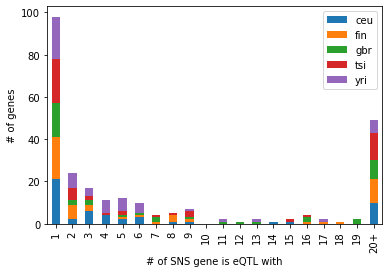

In [274]:
df.plot(kind='bar', stacked=True, x='index', xlabel='# of SNS gene is eQTL with', ylabel='# of genes')
plt.savefig('stackedbplot', bbox_inches='tight')

In [275]:
ceu

,gene,snp,pos,slope,SE,pvalue
0,ENSG00000206140.5,rs149314796,21536068,4.724768,0.563468,2.012902e-12
1,ENSG00000206140.5,rs464965,21823602,4.724768,0.563468,2.012902e-12
2,ENSG00000131100.8,rs8190348,18219630,33.410892,4.800155,1.042666e-09
3,ENSG00000131100.8,rs8190330,18222567,33.410892,4.800155,1.042666e-09
4,ENSG00000131100.8,rs8190329,18222623,33.410892,4.800155,1.042666e-09
...,...,...,...,...,...,...
726,ENSG00000217442.3,rs76081526,50991787,0.466590,0.058882,1.537770e-11
727,ENSG00000217442.3,rs78789402,51001271,0.618530,0.064149,7.937542e-15
728,ENSG00000217442.3,rs11913936,51004170,0.427857,0.067367,1.424907e-08
729,ENSG00000217442.3,rs5741862,51063233,0.504333,0.068713,1.999982e-10


In [276]:
yri

,gene,snp,pos,slope,SE,pvalue
0,ENSG00000253239.1,rs76032591,22046732,398.021903,38.726053,5.758036e-16
1,ENSG00000253239.1,rs9610168,22077719,398.021903,38.726053,5.758036e-16
2,ENSG00000253239.1,rs4821846,22558460,327.112378,20.084231,2.437779e-26
3,ENSG00000128322.6,rs5760118,24266801,2.750781,0.440233,2.291733e-08
4,ENSG00000128322.6,rs138659939,24330520,2.750781,0.440233,2.291733e-08
...,...,...,...,...,...,...
557,ENSG00000172250.10,rs5751302,42939639,1.514917,0.214939,7.543228e-10
558,ENSG00000172250.10,rs5758798,42939708,1.331211,0.207119,1.076932e-08
559,ENSG00000249222.1,rs34665484,43475261,2.814654,0.412755,2.022362e-09
560,ENSG00000100211.6,rs6001299,39294066,9.798328,1.434835,1.939805e-09


In [277]:
yri.set_index(['gene', 'snp'])

pos       slope         SE        pvalue
gene               snp                                                       
ENSG00000253239.1  rs76032591   22046732  398.021903  38.726053  5.758036e-16
                   rs9610168    22077719  398.021903  38.726053  5.758036e-16
                   rs4821846    22558460  327.112378  20.084231  2.437779e-26
ENSG00000128322.6  rs5760118    24266801    2.750781   0.440233  2.291733e-08
                   rs138659939  24330520    2.750781   0.440233  2.291733e-08
...                                  ...         ...        ...           ...
ENSG00000172250.10 rs5751302    42939639    1.514917   0.214939  7.543228e-10
                   rs5758798    42939708    1.331211   0.207119  1.076932e-08
ENSG00000249222.1  rs34665484   43475261    2.814654   0.412755  2.022362e-09
ENSG00000100211.6  rs6001299    39294066    9.798328   1.434835  1.939805e-09
ENSG00000217442.3  rs78789402   51001271    0.334683   0.049858  3.191391e-09

[562 rows x 4 columns]

In [278]:
xyplt = pd.merge(gbr.set_index(['gene', 'snp']), ceu.set_index(['gene', 'snp']), left_index=True, right_index=True)

In [279]:
xyplt

pos_x   slope_x      SE_x      pvalue_x  \
gene              snp                                                      
ENSG00000185065.6 rs75637138  19440597 -0.107153  0.015877  1.876234e-09   
                  rs2238769   19453727 -0.107153  0.015877  1.876234e-09   
                  rs2238770   19457743 -0.107153  0.015877  1.876234e-09   
                  rs17811336  19458412 -0.107153  0.015877  1.876234e-09   
                  rs75077817  19461105 -0.107153  0.015877  1.876234e-09   
...                                ...       ...       ...           ...   
ENSG00000217442.3 rs41281531  50989537  0.557692  0.049484  2.066668e-18   
                  rs76081526  50991787  0.557692  0.049484  2.066668e-18   
                  rs78789402  51001271  0.626433  0.043578  3.067227e-24   
                  rs11913936  51004170  0.418772  0.051698  4.104968e-12   
                  rs5741862   51063233  0.514579  0.054824  1.103043e-14   

                                 pos_y   slope_y      SE_y      pvalue_y  
gene              snp                                                     
ENSG00000185065.6 rs75637138  19440597 -0.114408  0.016983  2.741350e-09  
                  rs2238769   19453727 -0.114408  0.016983  2.741350e-09  
                  rs2238770   19457743 -0.114408  0.016983  2.741350e-09  
                  rs17811336  19458412 -0.114408  0.016983  2.741350e-09  
                  rs75077817  19461105 -0.114408  0.016983  2.741350e-09  
...                                ...       ...       ...           ...  
ENSG00000217442.3 rs41281531  50989537  0.466590  0.058882  1.537770e-11  
                  rs76081526  50991787  0.466590  0.058882  1.537770e-11  
                  rs78789402  51001271  0.618530  0.064149  7.937542e-15  
                  rs11913936  51004170  0.427857  0.067367  1.424907e-08  
                  rs5741862   51063233  0.504333  0.068713  1.999982e-10  

[352 rows x 8 columns]

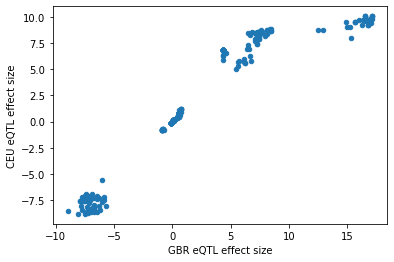

In [280]:
xyplt.plot(kind='scatter', x='slope_x', y='slope_y', xlabel='GBR eQTL effect size', ylabel='CEU eQTL effect size')
plt.savefig('scatter', bbox_inches='tight')

In [281]:
dotplt = pd.merge(ceu.set_index(['gene', 'snp']), fin.set_index(['gene', 'snp']), left_index=True, right_index=True, suffixes = ['_ceu', '_fin'])
dotplt = pd.merge(dotplt, gbr.set_index(['gene', 'snp']), left_index=True, right_index=True)
dotplt = pd.merge(dotplt, tsi.set_index(['gene', 'snp']), left_index=True, right_index=True, suffixes=['_gbr', '_tsi'])
dotplt = pd.merge(dotplt, yri.set_index(['gene', 'snp']), left_index=True, right_index=True)


In [282]:
dotplt

pos_ceu  slope_ceu    SE_ceu    pvalue_ceu  \
gene              snp                                                        
ENSG00000100058.7 rs6004655    25855629   6.787726  0.774189  3.721913e-13   
ENSG00000244752.2 rs112980920  25844027   0.842508  0.100998  2.437157e-12   
                  rs7288843    25844095   1.215259  0.128030  1.532579e-14   
                  rs7289954    25844116   1.215259  0.128030  1.532579e-14   
                  rs3198642    25844147   1.215259  0.128030  1.532579e-14   
...                                 ...        ...       ...           ...   
ENSG00000100376.7 rs136610     45794212   9.683360  1.119112  6.177694e-13   
                  rs5765327    45800926   9.683360  1.119112  6.177694e-13   
                  rs62231146   45807538   9.683360  1.119112  6.177694e-13   
                  rs12106522   45808036   9.683360  1.119112  6.177694e-13   
ENSG00000217442.3 rs78789402   51001271   0.618530  0.064149  7.937542e-15   

                                pos_fin  slope_fin    SE_fin    pvalue_fin  \
gene              snp                                                        
ENSG00000100058.7 rs6004655    25855629   5.200914  0.722252  2.017347e-10   
ENSG00000244752.2 rs112980920  25844027   0.625497  0.087395  2.467308e-10   
                  rs7288843    25844095   0.827565  0.113643  1.388977e-10   
                  rs7289954    25844116   0.827565  0.113643  1.388977e-10   
                  rs3198642    25844147   0.827565  0.113643  1.388977e-10   
...                                 ...        ...       ...           ...   
ENSG00000100376.7 rs136610     45794212  13.499042  0.897429  6.266291e-26   
                  rs5765327    45800926  13.499042  0.897429  6.266291e-26   
                  rs62231146   45807538  13.499042  0.897429  6.266291e-26   
                  rs12106522   45808036  13.499042  0.897429  6.266291e-26   
ENSG00000217442.3 rs78789402   51001271   0.685385  0.059598  3.763488e-19   

                                pos_gbr  slope_gbr    SE_gbr    pvalue_gbr  \
gene              snp                                                        
ENSG00000100058.7 rs6004655    25855629   4.295667  0.687893  1.725362e-08   
ENSG00000244752.2 rs112980920  25844027   0.554003  0.075394  1.271578e-10   
                  rs7288843    25844095   0.779129  0.112640  8.859843e-10   
                  rs7289954    25844116   0.779129  0.112640  8.859843e-10   
                  rs3198642    25844147   0.779129  0.112640  8.859843e-10   
...                                 ...        ...       ...           ...   
ENSG00000100376.7 rs136610     45794212  16.723943  0.996412  2.073331e-28   
                  rs5765327    45800926  16.529260  0.816123  7.267340e-34   
                  rs62231146   45807538  16.372459  1.034792  8.785829e-27   
                  rs12106522   45808036  16.723943  0.996412  2.073331e-28   
ENSG00000217442.3 rs78789402   51001271   0.626433  0.043578  3.067227e-24   

                                pos_tsi  slope_tsi    SE_tsi    pvalue_tsi  \
gene              snp                                                        
ENSG00000100058.7 rs6004655    25855629   6.910716  0.813282  3.817290e-13   
ENSG00000244752.2 rs112980920  25844027   0.905289  0.089028  1.276463e-16   
                  rs7288843    25844095   1.086197  0.115003  4.077437e-15   
                  rs7289954    25844116   1.086197  0.115003  4.077437e-15   
                  rs3198642    25844147   1.086197  0.115003  4.077437e-15   
...                                 ...        ...       ...           ...   
ENSG00000100376.7 rs136610     45794212  11.424163  1.078138  1.662761e-17   
                  rs5765327    45800926  11.424163  1.078138  1.662761e-17   
                  rs62231146   45807538  10.676208  1.108936  1.700224e-15   
                  rs12106522   45808036  10.676208  1.108936  1.700224e-15   
ENSG00000217442.3 rs78789402   51001271   0.416964 

In [283]:
test = dotplt[dotplt['pvalue_gbr'] == dotplt['pvalue_gbr'].min()][['slope_ceu', 'SE_ceu', 'slope_gbr', 'SE_gbr', 'slope_fin', 'SE_fin', 'slope_tsi', 'SE_tsi', 'slope', 'SE']].iloc[0]

In [284]:
dotplt[dotplt['pvalue_gbr'] == dotplt['pvalue_gbr'].min()]

pos_ceu  slope_ceu    SE_ceu    pvalue_ceu  \
gene              snp                                                      
ENSG00000100376.7 rs104664   45711854  10.056694  1.031751  5.008099e-15   
                  rs2142552  45719497  10.056694  1.031751  5.008099e-15   
                  rs7285172  45726345  10.056694  1.031751  5.008099e-15   

                              pos_fin  slope_fin    SE_fin    pvalue_fin  \
gene              snp                                                      
ENSG00000100376.7 rs104664   45711854  13.499042  0.897429  6.266291e-26   
                  rs2142552  45719497  13.499042  0.897429  6.266291e-26   
                  rs7285172  45726345  13.499042  0.897429  6.266291e-26   

                              pos_gbr  slope_gbr    SE_gbr    pvalue_gbr  \
gene              snp                                                      
ENSG00000100376.7 rs104664   45711854  17.124202  0.690978  4.082992e-40   
                  rs2142552  45719497  17.124202  0.690978  4.082992e-40   
                  rs7285172  45726345  17.124202  0.690978  4.082992e-40   

                              pos_tsi  slope_tsi    SE_tsi    pvalue_tsi  \
gene              snp                                                      
ENSG00000100376.7 rs104664   45711854  11.424163  1.078138  1.662761e-17   
                  rs2142552  45719497  11.424163  1.078138  1.662761e-17   
                  rs7285172  45726345  11.424163  1.078138  1.662761e-17   

                                  pos      slope        SE        pvalue  
gene              snp                                                     
ENSG00000100376.7 rs104664   45711854  12.768327  1.953753  6.807820e-09  
                  rs2142552  45719497  15.177424  1.954364  3.324071e-11  
                  rs7285172  45726345  15.177424  1.954364  3.324071e-11

In [285]:
y = [test['slope_ceu'], test['slope_fin'], test['slope_gbr'], test['slope_tsi'], test['slope']]
y_err = [test['SE_ceu'], test['SE_fin'], test['SE_gbr'], test['SE_tsi'], test['SE']]
y

[10.056694212412822,
 13.499042180544214,
 17.124202009109,
 11.424162783114324,
 12.76832691227044]

In [286]:
y_err

[1.031751390401832,
 0.8974289552308422,
 0.6909779294762818,
 1.0781384513240044,
 1.953753497466146]

In [287]:
x = ['CEU', 'FIN', 'GBR', 'TSI', 'YRI']

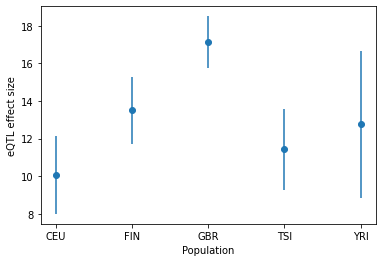

In [288]:
plt.errorbar(x, y, yerr = [2 * e for e in y_err], ls='none', fmt='o')
plt.ylabel('eQTL effect size')
plt.xlabel('Population')
plt.savefig('dotplot', bbox_inches='tight')